# Training notebook

This notebook contains the training code for the Starbucks Capstone Challenge.

It has got the following structure:
* Checking the correlation of the features in the training data
* Based on this seleceting the sufficient features
* Shuffleing the data
* splitting the data into train, validation and test sets
* evaluating the benchmark model kNN
* Training a feed forward neural network for classification with 4 classes:
    * creating data loaders
    * defining the model
    * finding sufficient hyperparameters
    * training the models
    * evaluating the trained model
* Extra experiment: Training a feed forward neural network for binary classification:
    * creating the binary labels from the 4 original classes
    * creating data loaders
    * defining the model
    * finding sufficient hyperparameters
    * training the models
    * evaluating the trained model
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from source import training_helpers
from source import model
from source.model import Linear_NN
from source import solver

In [2]:
# setting up torch device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('cuda is avalilabe' if torch.cuda.is_available() else 'cuda is NOT avaliable')

cuda is avalilabe


In [3]:
reload(training_helpers)
reload(model)
reload(solver)
from source.model import Linear_NN
from source.solver import NN_Solver

### loading the dataset and checking feature correlation

In [79]:
# loading the data:
data_dir = 'data'
data_file = 'training_data_standardized.csv'
training_data_df = training_helpers.load_training_data(data_dir=data_dir, data_file=data_file)
training_data_df.head()

Read training data from data/training_data_standardized.csv


,F,M,O,U,age,income,membership_length,av_money_spent,num_received,viewed/received,...,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,informational,bogo,discount,label
0,1.0,0.0,0.0,0.0,1.193501,1.654475,0.132255,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,0,0,1,0,3
1,0.0,0.0,0.0,1.0,0.000000,0.000000,-0.011285,-0.763102,-1.206595,-1.292364,...,1,0,0,0,0,0,0,0,1,2
2,0.0,1.0,0.0,0.0,0.792728,0.253302,-1.245015,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,1,0,0,1,2
3,0.0,0.0,0.0,1.0,0.000000,0.000000,-0.253576,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,0,0,1,0,2
4,0.0,1.0,0.0,0.0,0.620969,-0.540695,-0.865163,-0.763102,-1.206595,-1.292364,...,0,0,0,0,1,0,0,1,0,1


### cross entropy weights
As it was seen in the feature engineering dataset, there are different amount of training samples for each class, so weighing during training is necessary.

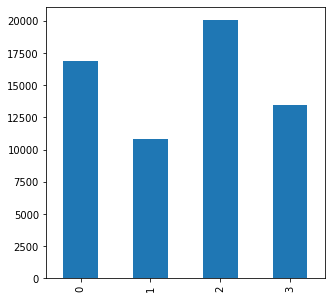

In [5]:
# chceking the number of labels in the dataset:
label_counts_df = training_data_df.label.value_counts().sort_index()
fig = plt.figure(figsize=(5,5))
label_counts_df.plot.bar()

In [6]:
# creating weighing factor for the cross entropy loss:
label_counts = training_data_df.label.value_counts().sort_index().values

cross_entropy_weights = label_counts.mean() / label_counts
print('cross entropy weights of the classes: {}'.format(cross_entropy_weights))
# putting it into a tensor on cuda:
cross_entropy_weights = torch.as_tensor(cross_entropy_weights, dtype=torch.float).to(device)

cross entropy weights of the classes: [0.9069451  1.41665127 0.76273632 1.1357979 ]


### Correlation matrix

In [7]:
# checking the correlation matrix:
training_data_df.corr()

,F,M,O,U,age,income,membership_length,av_money_spent,num_received,viewed/received,...,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,informational,bogo,discount,label
F,1.000000,-0.742123,-0.080854,-0.288567,0.144789,0.222408,0.011123,0.198040,-0.004785,0.001956,...,0.006749,-0.004738,-0.004614,0.004370,-0.002159,-0.002574,0.004166,-0.000412,-0.003275,0.053173
M,-0.742123,1.000000,-0.110272,-0.393560,-0.137893,-0.210736,-0.003784,-0.035368,0.002142,-0.027004,...,-0.002849,0.003803,0.005320,-0.004631,-0.000889,0.002432,-0.002820,-0.002588,0.005196,-0.014170
O,-0.080854,-0.110272,1.000000,-0.042878,-0.003326,-0.013558,-0.009273,0.018863,-0.004134,0.012073,...,0.002979,0.002733,-0.000603,0.002963,-0.001584,-0.002334,0.002745,-0.003873,0.001585,0.016564
U,-0.288567,-0.393560,-0.042878,1.000000,0.000406,0.001730,-0.007125,-0.232751,0.004901,0.033187,...,-0.006255,0.000195,-0.001151,-0.000275,0.004855,0.000786,-0.002587,0.005630,-0.003552,-0.059276
age,0.144789,-0.137893,-0.003326,0.000406,1.000000,0.300572,0.020466,0.080883,-0.001565,0.014495,...,0.002606,-0.000767,-0.000065,0.005979,0.000075,-0.005924,0.007731,-0.003986,-0.002729,0.029149
income,0.222408,-0.210736,-0.013558,0.001730,0.300572,1.000000,0.047885,0.244121,-0.006509,0.028156,...,-0.001267,-0.000318,-0.005584,0.003583,0.002338,-0.002103,0.003298,0.002279,-0.005300,0.061189
membership_length,0.011123,-0.003784,-0.009273,-0.007125,0.020466,0.047885,1.000000,0.176122,0.000882,0.006887,...,0.000589,-0.010036,0.001721,0.001926,-0.005336,-0.000274,0.001767,0.003396,-0.005100,0.070948
av_money_spent,0.198040,-0.035368,0.018863,-0.232751,0.080883,0.244121,0.176122,1.000000,0.313841,0.396038,...,-0.019673,-0.011763,-0.036415,0.021134,0.016454,-0.005191,0.029876,0.014563,-0.041691,0.077541
num_received,-0.004785,0.002142,-0.004134,0.004901,-0.001565,-0.006509,0.000882,0.313841,1.000000,0.516739,...,-0.108061,-0.024229,-0.105950,0.067890,0.069505,-0.026006,0.107171,0.053206,-0.150555,-0.023747
viewed/received,0.001956,-0.027004,0.012073,0.033187,0.014495,0.028156,0.006887,0.396038,0.516739,1.000000,...,-0.035243,-0.002591,-0.042932,0.019774,0.027679,-0.005509,0.032227,0.019186,-0.048585,0.018606


The features does not seem to be correlated to eachother

### Extracting the training features and the labels

It is possible to use all the data features for inference, however it is possible that some features are not that meaningful as others. For this in the following cells two kinds of methods is implemented. In the first one one is able to load the total feature vector. In the second one only some of the features are loaded, the ones which were chosen by column name in the dataframe

In [8]:
# This cell has to be run to generate the training set if all of the features would like to be used for training.
X = training_data_df.values[:, :-1].astype(np.float32)
y = training_data_df.values[:, -1].astype(np.float32)

# deleting the original dataframe:
#training_data_df = None

In [9]:
training_data_df.columns

Index(['F', 'M', 'O', 'U', 'age', 'income', 'membership_length',
       'av_money_spent', 'num_received', 'viewed/received', 'completed/viewed',
       'completed_not_viewed', 'num_received_this', 'viewed/received_this',
       'completed/viewed_this', 'completed_not_viewed_this', 'offer_0',
       'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5', 'offer_6',
       'offer_7', 'offer_8', 'offer_9', 'informational', 'bogo', 'discount',
       'label'],
      dtype='object')

In [10]:
# By generating the training data with this cell, only some training features are going to be used.
# selecting only some features:
columns = ['F', 'M', 'O', 'U', 'age', 'income', 'membership_length',
           'av_money_spent', 'num_received', 'viewed/received', 'completed/viewed', 
           'num_received_this', 'viewed/received_this', 'completed/viewed_this', 'completed_not_viewed_this',
           'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4', 'offer_5', 'offer_6',
           'offer_7', 'offer_8', 'offer_9']
X = training_data_df.loc[:, columns].values.astype(np.float32)
y = training_data_df.label.values.astype(np.float32)

### Shuffleing and splitting the data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0, shuffle=True)
print('training size: {}'.format(X_train.shape))
print('validation size: {}'.format(X_val.shape))
print('test size: {}'.format(X_test.shape))

training size: (49671, 25)
validation size: (5520, 25)
test size: (6133, 25)


## Checking the acquirable accuracy with kNN

Our benchmark model is a kNN classifier (k Nearest Neighbours). We are going to use sklearn's KNeighborsClassifier for this purpose.

In [85]:
model_kNN = KNeighborsClassifier(n_neighbors=10)
model_kNN.fit(X_train, y_train)

y_val_pred = model_kNN.predict(X_val)

accuracy_val_kNN = np.mean(y_val_pred == y_val)
print('kNN validation accuracy: {}'.format(accuracy_val_kNN))


kNN validation accuracy: 0.463768115942029


## Defining a training a feed forward neural network.

The network implementation can be found in `source/model.py`.

The solver implementation can be founf in `source.solver.py`

* First the data loaders are created.
* we check the implementation by overfitting to a single data instance
* train the feed forward model for 4 class classification
* train the feed forward model for binary classification

### Creating the data loader

In [12]:
# converting the data into torch.tensor:
X_train = torch.as_tensor(X_train, dtype=torch.float).to(device)
X_val = torch.as_tensor(X_val, dtype=torch.float).to(device)
X_test = torch.as_tensor(X_test, dtype=torch.float).to(device)

y_train = torch.as_tensor(y_train, dtype=torch.long).to(device)
y_val = torch.as_tensor(y_val, dtype=torch.long).to(device)
y_test = torch.as_tensor(y_test, dtype=torch.long).to(device)

In [13]:
# creating datasets for the dataloaders:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 512
# creating the data loaders:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## overfitting to a single data instance
First we are checking the implementation by overfitting ot a single data instance:

In [44]:
# creating data loaders for a single training insctance:
X_train_single = torch.as_tensor(X_train[0, :].reshape(1, -1), dtype=torch.float).to(device)
X_val_single = torch.as_tensor(X_val[0, :].reshape(1, -1), dtype=torch.float).to(device)

y_train_single = torch.as_tensor(y_train[0].reshape(1), dtype=torch.long).to(device)
y_val_single = torch.as_tensor(y_val[0].reshape(1), dtype=torch.long).to(device)

In [45]:
# network parameters:
input_dim = X_train.shape[1]
output_dim = 4
hidden_dims = [64]
dropout = 0.0

In [46]:
# testing the model by overfitting to a single data instance:
train_dataset_single = TensorDataset(X_train_single, y_train_single)
val_dataset_single = TensorDataset(X_val_single, y_val_single)
train_loader_single = torch.utils.data.DataLoader(train_dataset_single,
                                                batch_size=1, shuffle=False, num_workers=0)
val_loader_single = torch.utils.data.DataLoader(val_dataset_single,
                                              batch_size=1, shuffle=False, num_workers=0)

test_model = Linear_NN(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, dropout=dropout)
test_model.to(device)
NN_solver = NN_Solver(optim_args={"lr": 5e-3, "weight_decay": 0},
                loss_func=torch.nn.CrossEntropyLoss())
best_state_dict = NN_solver.train(test_model, train_loader_single, val_loader_single, log_nth=100, num_epochs=30)

START TRAINING
Epoch 0/29
learning rate : 0.005
----------
Iteration 0/1 train accuracy: 0.0, train_loss: 1.3149421215057373
EPOCH 0/29 TRAIN loss/acc : 1.315/0.00%
EPOCH 0/29 VAL loss/acc : 1.584/0.00%
----------
Epoch 1/29
learning rate : 0.005
----------
EPOCH 1/29 TRAIN loss/acc : 1.189/100.00%
EPOCH 1/29 VAL loss/acc : 1.584/0.00%
----------
Epoch 2/29
learning rate : 0.005
----------
EPOCH 2/29 TRAIN loss/acc : 1.067/100.00%
EPOCH 2/29 VAL loss/acc : 1.585/0.00%
----------
Epoch 3/29
learning rate : 0.005
----------
EPOCH 3/29 TRAIN loss/acc : 0.965/100.00%
EPOCH 3/29 VAL loss/acc : 1.586/0.00%
----------
Epoch 4/29
learning rate : 0.005
----------
EPOCH 4/29 TRAIN loss/acc : 0.889/100.00%
EPOCH 4/29 VAL loss/acc : 1.587/0.00%
----------
Epoch 5/29
learning rate : 0.005
----------
EPOCH 5/29 TRAIN loss/acc : 0.836/100.00%
EPOCH 5/29 VAL loss/acc : 1.589/0.00%
----------
Epoch 6/29
learning rate : 0.005
----------
EPOCH 6/29 TRAIN loss/acc : 0.803/100.00%
EPOCH 6/29 VAL loss/acc :

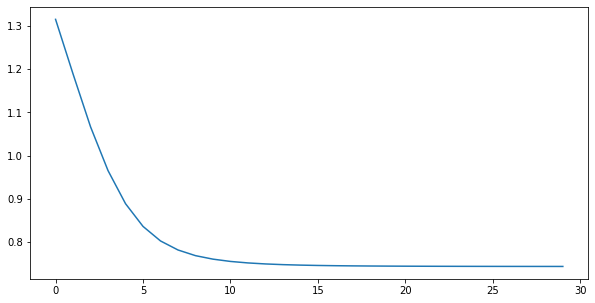

In [47]:
# printing the train loss history:
fig = plt.figure(figsize=(10, 5))
plt.plot(NN_solver.train_loss_history)

plt.show()

### Training on the whole dataset.

After we have validated that the model learns, since it was able to overfit to a single data instance, we can train a more complex architecture on the whole training dataset.

In [94]:
# network parameters:
input_dim = X_train.shape[1]
output_dim = 4
hidden_dims = [256, 512, 512, 128]
dropout = 0.2

In [95]:
# instantiating the model:
model_NN = Linear_NN(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim,
                     dropout=dropout, activation='leaky_relu')
model_NN.to(device)

saving_path = 'models/NN_model.pth'

NN_solver = NN_Solver(optim_args={"lr": 1e-4, "weight_decay": 0},
            loss_func=torch.nn.CrossEntropyLoss(weight=cross_entropy_weights))
NN_solver.train(model_NN, train_loader, val_loader, log_nth=0, num_epochs=100, saving_path=saving_path)

START TRAINING
Epoch 0/99
learning rate : 0.0001
----------
EPOCH 0/99 TRAIN loss/acc : 2.681/32.86%
EPOCH 0/99 VAL loss/acc : 2.619/42.10%
----------
Epoch 1/99
learning rate : 0.0001
----------
EPOCH 1/99 TRAIN loss/acc : 2.578/39.77%
EPOCH 1/99 VAL loss/acc : 2.514/47.25%
----------
Epoch 2/99
learning rate : 0.0001
----------
EPOCH 2/99 TRAIN loss/acc : 2.526/42.89%
EPOCH 2/99 VAL loss/acc : 2.466/49.58%
----------
Epoch 3/99
learning rate : 0.0001
----------
EPOCH 3/99 TRAIN loss/acc : 2.511/44.35%
EPOCH 3/99 VAL loss/acc : 2.452/49.53%
----------
Epoch 4/99
learning rate : 0.0001
----------
EPOCH 4/99 TRAIN loss/acc : 2.496/44.97%
EPOCH 4/99 VAL loss/acc : 2.444/49.86%
----------
Epoch 5/99
learning rate : 0.0001
----------
EPOCH 5/99 TRAIN loss/acc : 2.494/44.95%
EPOCH 5/99 VAL loss/acc : 2.438/49.73%
----------
Epoch 6/99
learning rate : 0.0001
----------
EPOCH 6/99 TRAIN loss/acc : 2.489/45.34%
EPOCH 6/99 VAL loss/acc : 2.435/50.63%
----------
Epoch 7/99
learning rate : 0.0001

EPOCH 59/99 TRAIN loss/acc : 2.459/47.01%
EPOCH 59/99 VAL loss/acc : 2.419/51.49%
----------
Epoch 60/99
learning rate : 0.0001
----------
EPOCH 60/99 TRAIN loss/acc : 2.457/47.39%
EPOCH 60/99 VAL loss/acc : 2.419/51.47%
----------
Epoch 61/99
learning rate : 0.0001
----------
EPOCH 61/99 TRAIN loss/acc : 2.456/47.45%
EPOCH 61/99 VAL loss/acc : 2.419/51.47%
----------
Epoch 62/99
learning rate : 0.0001
----------
EPOCH 62/99 TRAIN loss/acc : 2.452/47.57%
EPOCH 62/99 VAL loss/acc : 2.419/51.30%
----------
Epoch 63/99
learning rate : 0.0001
----------
EPOCH 63/99 TRAIN loss/acc : 2.453/47.38%
EPOCH 63/99 VAL loss/acc : 2.420/51.05%
----------
Epoch 64/99
learning rate : 0.0001
----------
EPOCH 64/99 TRAIN loss/acc : 2.455/47.40%
EPOCH 64/99 VAL loss/acc : 2.417/51.78%
----------
Epoch 65/99
learning rate : 0.0001
----------
EPOCH 65/99 TRAIN loss/acc : 2.458/47.00%
EPOCH 65/99 VAL loss/acc : 2.416/51.59%
----------
Epoch 66/99
learning rate : 0.0001
----------
EPOCH 66/99 TRAIN loss/acc 

best validation accuracy: 0.5206521739130435


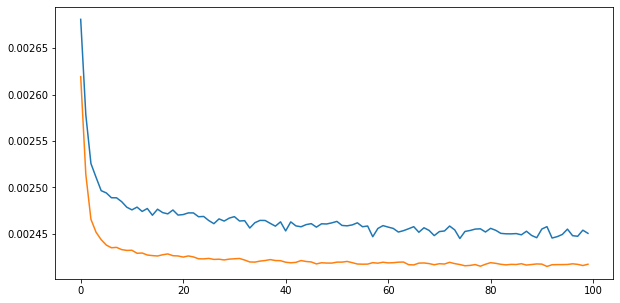

In [97]:
# printing the train and validation loss history:
fig = plt.figure(figsize=(10, 5))
plt.plot(NN_solver.train_loss_history)
plt.plot(NN_solver.val_loss_history)

print('best validation accuracy: {}'.format(max(NN_solver.val_acc_history)))

plt.show()

### Testing

After the hyper parameters were set with the help of the validation set, the mosel can be tested on the test set.

In [100]:
# testing the trained model:
model_NN.eval()
output = model_NN(X_test)
pred_labels = output.argmax(dim=1)

test_accuracy = np.mean((pred_labels == y_test).cpu().numpy())
print('test accuracy: {}'.format(test_accuracy))

test accuracy: 0.5196478069460296


In [102]:
# some sample labels:
print('predicted: {}'.format(pred_labels[500: 520]))
print('real:      {}'.format(y_test[500: 520]))

predicted: tensor([2, 2, 3, 3, 3, 0, 3, 0, 3, 3, 2, 3, 1, 3, 3, 3, 2, 2, 3, 0],
       device='cuda:0', grad_fn=<SliceBackward>)
real:      tensor([1, 0, 3, 3, 3, 2, 3, 0, 3, 3, 2, 0, 3, 2, 3, 2, 2, 0, 3, 0],
       device='cuda:0')


## Training a Neural net only for classifying succesful and not succesful offers

Cathegorizing the offers into succesful and not succesful. Labels 0 and 1 correspond to not succesful offers and labels 2 and 3 correspond to succesful ones.

In [101]:
# By generating the training data with this cell, only some training features are going to be used.
# selecting only some features:
columns = ['F', 'M', 'O', 'U', 'age', 'income', 'membership_length',
           'av_money_spent', 'num_received', 'viewed/received', 'completed/viewed', 
           'num_received_this', 'viewed/received_this', 'completed/viewed_this', 'completed_not_viewed_this',
           'offer_0', 'offer_1', 'offer_2', 'offer_3', 'offer_4',
           'offer_5', 'offer_6', 'offer_7', 'offer_8', 'offer_9']
X = training_data_df.loc[:, columns].values.astype(np.float32)

In [114]:
# normal successful offers:
mask_1 = training_data_df.label > 2.5
# informational successful offers:
mask_2 = ((training_data_df.offer_2 == 1) | (training_data_df.offer_7 == 1)) & (training_data_df.label == 2)
# every successful offer:
success_df = mask_1 | mask_2
print('number of succesful points: {}'.format(success_df.sum()))
print('number of not succesful points: {}'.format(len(success_df.values) - success_df.sum()))

y = success_df.values.astype(np.float)

number of succesful points: 20964
number of not succesful points: 40360


In [115]:
training_data_df.head()

,F,M,O,U,age,income,membership_length,av_money_spent,num_received,viewed/received,...,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,informational,bogo,discount,label
0,1.0,0.0,0.0,0.0,1.193501,1.654475,0.132255,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,0,0,1,0,3
1,0.0,0.0,0.0,1.0,0.000000,0.000000,-0.011285,-0.763102,-1.206595,-1.292364,...,1,0,0,0,0,0,0,0,1,2
2,0.0,1.0,0.0,0.0,0.792728,0.253302,-1.245015,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,1,0,0,1,2
3,0.0,0.0,0.0,1.0,0.000000,0.000000,-0.253576,-0.763102,-1.206595,-1.292364,...,0,0,0,0,0,0,0,1,0,2
4,0.0,1.0,0.0,0.0,0.620969,-0.540695,-0.865163,-0.763102,-1.206595,-1.292364,...,0,0,0,0,1,0,0,1,0,1


In [131]:
# weighing factor for the cross entropy loss:
num_success = succesful_mask.sum()
num_unsuccess = len(succesful_mask.values) - num_success
average = (num_success + num_unsuccess) / 2
cross_entropy_weights = [average / num_unsuccess, average / num_success / 1.2]
print('cross entropy weights: {}'.format(cross_entropy_weights))

cross_entropy_weights = torch.as_tensor(cross_entropy_weights, dtype=torch.float).to(device)

cross entropy weights: [0.7010725458066438, 1.4527769546105596]


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)
print('training size: {}'.format(X_train.shape))
print('validation size: {}'.format(X_val.shape))
print('test size: {}'.format(X_test.shape))

training size: (49671, 25)
validation size: (5520, 25)
test size: (6133, 25)


### Benchmark kNN model:

In [133]:
model_kNN = KNeighborsClassifier(n_neighbors=5)
model_kNN.fit(X_train, y_train)

pred_labels = model_kNN.predict(X_test).astype(np.int8)
true_labels = y_test.astype(np.int8)

# binary classification performance measures:
TP = (pred_labels & true_labels).sum()
TN = ((1 - pred_labels) & (1 - true_labels)).sum()
FP = (pred_labels & (1 - true_labels)).sum()
FN = ((1 - pred_labels) & true_labels).sum()
print('True Positives: {}'.format(TP))
print('True Negatives: {}'.format(TN))
print('False Positives: {}'.format(FP))
print('False Negatives: {}'.format(FN))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
false_negative_rate = FN / (TP + FN)
print('accuracy: {}%'.format(accuracy * 100))
print('precision: {}%'.format(precision * 100))
print('recall: {}%'.format(recall * 100))
print('false negative rate: {}%'.format(false_negative_rate * 100))

True Positives: 867
True Negatives: 3189
False Positives: 861
False Negatives: 1216
accuracy: 66.13402902331649%
precision: 50.173611111111114%
recall: 41.62265962554009%
false negative rate: 58.37734037445992%


In [134]:
# converting the data into torch.tensor:
X_train = torch.as_tensor(X_train, dtype=torch.float).to(device)
X_val = torch.as_tensor(X_val, dtype=torch.float).to(device)
X_test = torch.as_tensor(X_test, dtype=torch.float).to(device)

y_train = torch.as_tensor(y_train, dtype=torch.long).to(device)
y_val = torch.as_tensor(y_val, dtype=torch.long).to(device)
y_test = torch.as_tensor(y_test, dtype=torch.long).to(device)

# creating datasets for the dataloaders:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 1024
# creating the data loaders:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### defining and training network for binary classification:

In [135]:
# network parameters:
input_dim = X_train.shape[1]
output_dim = 2
hidden_dims = [256, 512, 512, 128]
dropout = 0.2

In [136]:
# instantiating the model:
model_NN_binary = Linear_NN(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim,
                     dropout=dropout, activation='leaky_relu')
model_NN_binary.to(device)

saving_path = 'models/NN_model_binary.pth'

NN_solver_binary = NN_Solver(optim_args={"lr": 5e-5, "weight_decay": 0},
                loss_func=torch.nn.CrossEntropyLoss(weight=cross_entropy_weights))
NN_solver_binary.train(model_NN_binary, train_loader, val_loader,
                       log_nth=0, num_epochs=30, saving_path=saving_path)

START TRAINING
Epoch 0/29
learning rate : 5e-05
----------
EPOCH 0/29 TRAIN loss/acc : 0.678/44.28%
EPOCH 0/29 VAL loss/acc : 0.735/58.57%
----------
Epoch 1/29
learning rate : 5e-05
----------
EPOCH 1/29 TRAIN loss/acc : 0.665/55.94%
EPOCH 1/29 VAL loss/acc : 0.717/59.93%
----------
Epoch 2/29
learning rate : 5e-05
----------
EPOCH 2/29 TRAIN loss/acc : 0.651/59.07%
EPOCH 2/29 VAL loss/acc : 0.698/61.70%
----------
Epoch 3/29
learning rate : 5e-05
----------
EPOCH 3/29 TRAIN loss/acc : 0.642/60.31%
EPOCH 3/29 VAL loss/acc : 0.685/63.82%
----------
Epoch 4/29
learning rate : 5e-05
----------
EPOCH 4/29 TRAIN loss/acc : 0.636/60.53%
EPOCH 4/29 VAL loss/acc : 0.676/64.78%
----------
Epoch 5/29
learning rate : 5e-05
----------
EPOCH 5/29 TRAIN loss/acc : 0.633/61.25%
EPOCH 5/29 VAL loss/acc : 0.673/64.58%
----------
Epoch 6/29
learning rate : 5e-05
----------
EPOCH 6/29 TRAIN loss/acc : 0.630/61.36%
EPOCH 6/29 VAL loss/acc : 0.670/64.78%
----------
Epoch 7/29
learning rate : 5e-05
-------

best validation accuracy: 0.6568840579710145


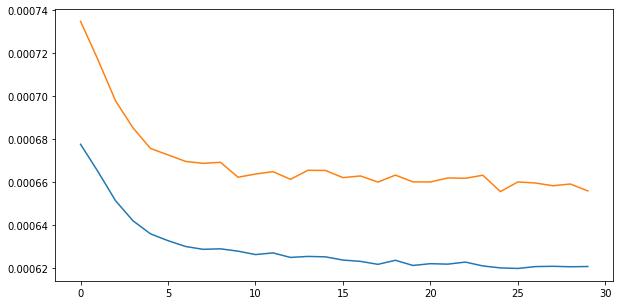

In [137]:
# printing the train and validation loss history:
fig = plt.figure(figsize=(10, 5))
plt.plot(NN_solver_binary.train_loss_history)
plt.plot(NN_solver_binary.val_loss_history)

print('best validation accuracy: {}'.format(max(NN_solver_binary.val_acc_history)))

plt.show()

### Testing

After the accuracy of the binary classifier the model can be tested on the test set.

In [138]:
# testing the trained model:
model_NN_binary.eval()
output = model_NN_binary(X_test)
pred_labels = output.argmax(dim=1).cpu().detach().numpy()
true_labels = y_test.cpu().numpy()
# binary classification performance measures:
TP = (pred_labels & true_labels).sum()
TN = ((1 - pred_labels) & (1 - true_labels)).sum()
FP = (pred_labels & (1 - true_labels)).sum()
FN = ((1 - pred_labels) & true_labels).sum()
print('True Positives: {}'.format(TP))
print('True Negatives: {}'.format(TN))
print('False Positives: {}'.format(FP))
print('False Negatives: {}'.format(FN))

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
false_negative_rate = FN / (TP + FN)
print('accuracy: {}%'.format(accuracy * 100))
print('precision: {}%'.format(precision * 100))
print('recall: {}%'.format(recall * 100))
print('false negative rate: {}%'.format(false_negative_rate * 100))

True Positives: 1565
True Negatives: 2424
False Positives: 1626
False Negatives: 518
accuracy: 65.04157834664927%
precision: 49.04418677530555%
recall: 75.13202112337974%
false negative rate: 24.86797887662026%


In [140]:
# some sample labels:
print('predicted: {}'.format(pred_labels[500: 520]))
print('real:      {}'.format(true_labels[500: 520]))

predicted: [1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0]
real:      [1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0]
